In [1]:
# libs
import pandas as pd
import matplotlib.pyplot as plt

# WPRDC Property Sales Transactions (2013–present)
RESOURCE_ID = "5bbe6c55-bce6-4edb-9d04-68edeb6bf7b1"
url = f"https://data.wprdc.org/datastore/dump/{RESOURCE_ID}"

# read table
df = pd.read_csv(url)
df.head()

/scratch/slurm-22836/ipykernel_1163036/2791685012.py:10: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,_id,PARID,FULL_ADDRESS,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,...,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
0,22438219,1010G00075000000,"0 HILL ST, SOUTH PARK, PA 15129",0.0,,NaN,HILL,ST,NaN,NaN,...,South Park,2022-07-06,2022-06-21,1.0,18965,534.0,H,MULTI-PARCEL SALE,DE,DEED
1,22438220,1075F00108000000,"4720 HIGHPOINT DR, GIBSONIA, PA 15044",4720.0,,NaN,HIGHPOINT,DR,NaN,NaN,...,Hampton,2012-09-27,2012-09-27,120000.0,15020,356.0,3,LOVE AND AFFECTION SALE,DE,DEED
2,22438221,0011A00237000000,"0 LOMBARD ST, PITTSBURGH, PA 15219",0.0,,NaN,LOMBARD,ST,NaN,NaN,...,3rd Ward - PITTSBURGH,2015-01-06,2015-01-06,1783.0,TR15,2.0,2,CITY TREASURER SALE,TS,TREASURER DEED
3,22438222,0011J00047000000,"1903 FORBES AVE, PITTSBURGH, PA 15219",1903.0,,NaN,FORBES,AVE,NaN,NaN,...,1st Ward - PITTSBURGH,2012-10-26,2012-10-26,4643.0,TR13,3.0,2,CITY TREASURER SALE,TS,TREASURER DEED
4,22438223,0011J00191000000,"1806 TUSTIN ST, PITTSBURGH, PA 15219",1806.0,,NaN,TUSTIN,ST,NaN,NaN,...,1st Ward - PITTSBURGH,2023-04-28,2023-04-28,44100.0,TR24,2.0,GV,GOVERNMENT SALE,TS,TREASURER DEED


In [2]:
# keep neighborhood/municipality label, sale date, and price
df = df[['MUNIDESC', 'SALEDATE', 'PRICE']].dropna()

# quick peek
df.head()

,MUNIDESC,SALEDATE,PRICE
0,South Park,2022-06-21,1.0
1,Hampton,2012-09-27,120000.0
2,3rd Ward - PITTSBURGH,2015-01-06,1783.0
3,1st Ward - PITTSBURGH,2012-10-26,4643.0
4,1st Ward - PITTSBURGH,2023-04-28,44100.0


In [10]:
# make dates real datetimes
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'], errors='coerce')

# keep recent sales (you can adjust the year if you want)
recent = df[df['SALEDATE'].dt.year >= 2020].copy()

# drop rows with bad dates just in case
recent = recent.dropna(subset=['SALEDATE'])
recent.head()

,MUNIDESC,SALEDATE,PRICE,NEIGHBORHOOD
0,South Park,2022-06-21,1.0,South Park
4,1st Ward - PITTSBURGH,2023-04-28,44100.0,PITTSBURGH
5,1st Ward - PITTSBURGH,2023-04-28,1719.0,PITTSBURGH
8,10th Ward - PITTSBURGH,2022-05-31,1.0,PITTSBURGH
10,12th Ward - PITTSBURGH,2023-12-16,26500.0,PITTSBURGH


In [12]:
# count sales per neighborhood/ward (fewer sales => more stable)
sales_by_neigh = (
    recent
    .groupby('MUNIDESC')
    .size()
    .reset_index(name='sales_count')
)

# convert to a score: invert and normalize to 0..1 for easy merging with your other metrics
# (lower sales_count -> higher score)
sales_by_neigh['inv'] = 1 / sales_by_neigh['sales_count']
sales_by_neigh['housing_stability_score'] = (
    (sales_by_neigh['inv'] - sales_by_neigh['inv'].min())
    / (sales_by_neigh['inv'].max() - sales_by_neigh['inv'].min())
)

# tidy columns
stability = sales_by_neigh[['MUNIDESC', 'sales_count', 'housing_stability_score']].copy()
# clean up neighborhood/ward names for easier reading
stability['clean_name'] = stability['MUNIDESC'].str.split(' - ').str[-1]
stability.sort_values('housing_stability_score', ascending=False).head(10)

,MUNIDESC,sales_count,housing_stability_score,clean_name
14,1st Ward - McKEESPORT,9,1.000000,McKEESPORT
158,Trafford,14,0.642424,Trafford
100,Haysville,17,0.528842,Haysville
95,Glenfield,30,0.299152,Glenfield
37,4th Ward - McKEESPORT,39,0.229837,McKEESPORT
57,Ben Avon Heights,40,0.224061,Ben Avon Heights
29,2nd Ward - McKEESPORT,42,0.213334,McKEESPORT
151,South Versailles,53,0.168805,South Versailles
39,5th Ward - McKEESPORT,59,0.151516,McKEESPORT
157,Thornburg,75,0.118934,Thornburg


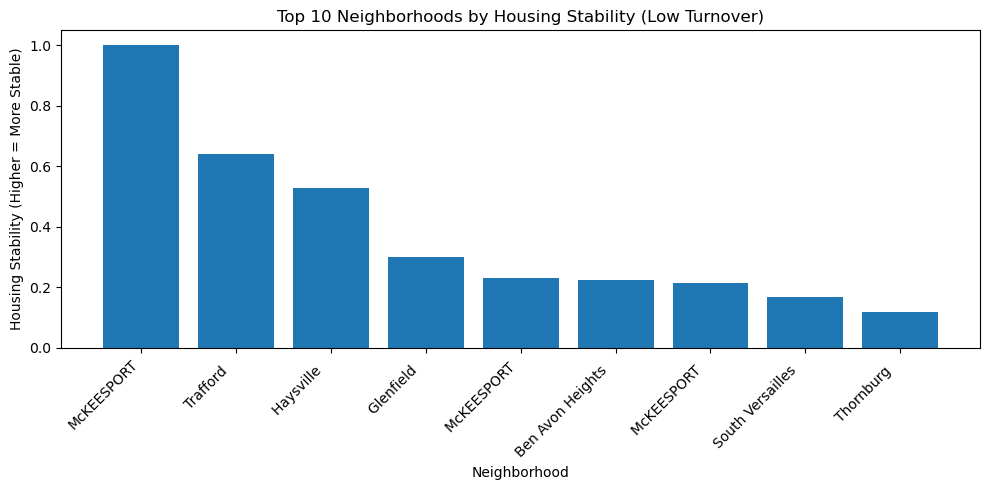

In [13]:
#Visualize top 10 most stable neighborhoods/wards
top10 = stability.sort_values('housing_stability_score', ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top10['clean_name'], top10['housing_stability_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Neighborhoods by Housing Stability (Low Turnover)')
plt.xlabel('Neighborhood')
plt.ylabel('Housing Stability (Higher = More Stable)')
plt.tight_layout()
plt.show()

In [24]:
stability.to_csv('housing_stability_by_neighborhood.csv', index=False)
stability.head()

,MUNIDESC,sales_count,housing_stability_score,clean_name
0,10th Ward - McKEESPORT,228,0.038310,McKEESPORT
1,10th Ward - PITTSBURGH,2646,0.002194,PITTSBURGH
2,11th Ward - McKEESPORT,336,0.025607,McKEESPORT
3,11th Ward - PITTSBURGH,1513,0.004744,PITTSBURGH
4,12th Ward - McKEESPORT,384,0.022254,McKEESPORT


In [14]:
# show neighborhood with best stability score
best = stability.sort_values('housing_stability_score', ascending=False).head(1)
best[['clean_name', 'sales_count', 'housing_stability_score']]

,clean_name,sales_count,housing_stability_score
14,McKEESPORT,9,1.0
